In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!nvidia-smi

Wed Jun  8 17:27:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
pip install underthesea

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 5.2 MB/s 
     |████████████████████████████████| 581 kB 51.0 MB/s 
     |████████████████████████████████| 235 kB 51.8 MB/s 
     |████████████████████████████████| 965 kB 45.1 MB/s 


In [5]:
%tensorflow_version 2.x

In [6]:
import pandas as pd
from itertools import chain
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import io
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import string
import re
from os.path import join
from underthesea import sent_tokenize,word_tokenize,pos_tag
from sklearn.metrics import *
from sklearn.utils.class_weight import compute_class_weight
from gensim.models import Word2Vec
from collections import Counter
import matplotlib.pyplot as plt

In [7]:
train=pd.read_csv("/content/drive/MyDrive/vietnamese_students_feedback/raw_dataset/train.csv")

In [8]:
valid=pd.read_csv("/content/drive/MyDrive/vietnamese_students_feedback/raw_dataset/valid.csv")

In [12]:
punctuations=list(string.punctuation)
def normalizer(text,joinf=False):
  def remove_symbols(s):
    return re.sub(r'\b(colon\w+)\b'," ",s)

  def remove_fraction(s):
    return re.sub(r'\b(fraction)\b','/',s)

  def replace_dot(s):
    return s.replace('dot','.')
    # return re.sub(r'\b(dot)\b',".",s)

  def replace_doubledot(s):
    return s.replace('doubledot',':')
    
  def uncased(s):
    return s.lower()

  def fix_whitespaces(s):
    return re.sub(r'\s+',' ',s)

  def remove_entities(s):
    return re.sub(r'\b((\w+|)wzjwz\d+)\b'," ",s)
  def remove_numbers(s):
    return re.sub(r'\d',' ',s)
  def remove_vv(s):
    return s.replace('v.v'," ")

  def remove_punctuations(s):
      return ''.join(ch for ch in s if ch not in punctuations)
  def norm_major(s):
      majors={
          'cnpm':"công nghệ phần mềm",
          'khmt':"khoa học máy tính",
          'ktmt':"kĩ thuật máy tính",
          'cntt':"công nghệ thông tin",
          'av1':"anh văn 1",
          'av2':"anh văn 2",
          'av3':"anh văn 3"
      }
      for k,v in majors.items():
        s=re.sub(r'\b({})\b'.format(k),v,s)
      return s
  def remove_ps(s):
    return s.replace("p / s"," ")

  def tokenizer(text):
    tokens=[]
    pos_tags=[]
    for sent in sent_tokenize(text):
      tags=pos_tag(remove_punctuations(sent))
      for token in tags:
          tokens.append(uncased(token[0]))
          pos_tags.append(f'{uncased(token[0])}|{token[1]}')
          
    return tokens,pos_tags

  norm_text=fix_whitespaces(remove_numbers(norm_major(remove_ps(remove_fraction(remove_vv(remove_entities(remove_symbols(replace_dot(replace_doubledot(text))))))))).strip())
  return tokenizer(norm_text)

In [13]:
train_x=train['sentence'].tolist()
train_y=train['topic'].tolist()

In [14]:
train_x=[normalizer(sample)for sample in train_x]

In [15]:
train_x[0]

(['slide', 'giáo trình', 'đầy đủ'], ['slide|N', 'giáo trình|V', 'đầy đủ|A'])

In [16]:
all_tokens=[s[0] for s in train_x]
all_tokens=list(chain.from_iterable(all_tokens))

In [17]:
counter=Counter(all_tokens)

In [18]:
counter.most_common(10)

[('thầy', 3044),
 ('sinh viên', 2683),
 ('dạy', 2162),
 ('và', 2068),
 ('không', 2061),
 ('rất', 1961),
 ('nhiệt tình', 1822),
 ('cho', 1724),
 ('có', 1709),
 ('hiểu', 1639)]

In [19]:
x,y=list(range(1,len(counter)+1)),list(counter.values())


In [20]:
def seq_len_visualizer(x,y):
  fig, ax = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(5,5))
  ax.bar(x,y)
  fig.show()

(None, 3395, 1)

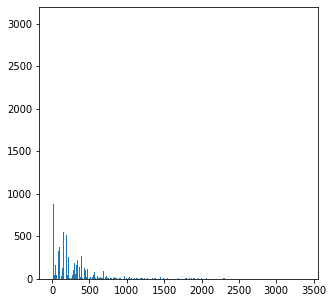

In [21]:
seq_len_visualizer(x,y),max(x),min(x)

In [22]:
all_pos_tags=[s[1] for s in train_x]
all_pos_tags=list(chain.from_iterable(all_pos_tags))

In [23]:
counter=Counter(all_pos_tags)

In [24]:
counter.most_common(10)

[('thầy|N', 3044),
 ('sinh viên|N', 2681),
 ('dạy|V', 2162),
 ('và|C', 2068),
 ('không|R', 2061),
 ('rất|R', 1961),
 ('có|V', 1705),
 ('hiểu|V', 1639),
 ('nhiều|A', 1621),
 ('cho|E', 1464)]

In [25]:
x,y=list(range(1,len(counter)+1)),list(counter.values())

In [26]:
def seq_len_visualizer(x,y):
  fig, ax = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(5,5))
  ax.bar(x,y)
  fig.show()

(None, 4640, 1)

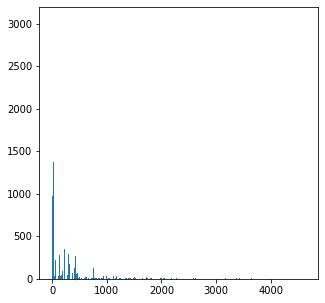

In [27]:
seq_len_visualizer(x,y),max(x),min(x)

#Train word2vec

In [28]:
min_count=1
window=3
size=300
alpha=1e-3
min_alpha=1e-4
negative=10
w2v_model = Word2Vec(min_count=min_count,window=window,size=size,alpha=alpha,min_alpha=min_alpha,negative=negative,sg=1)

In [29]:
word_sents=[sent[0] for sent in train_x]

In [30]:
w2v_model.build_vocab(word_sents)
w2v_model.train(word_sents, total_examples=w2v_model.corpus_count, epochs=100, report_delay=1,compute_loss=True)

(7589343, 10900200)

In [31]:
w2v_model.get_latest_training_loss()

21783310.0

In [32]:
w2v_model.wv.most_similar(word_sents[0][0]),word_sents[0][0]

([('bài giảng', 0.9076522588729858),
  ('đọc', 0.9047914743423462),
  ('giáo trình', 0.8956400156021118),
  ('giao tiếp', 0.879784107208252),
  ('việt', 0.8703510761260986),
  ('bằng', 0.8688735961914062),
  ('rõ ràng', 0.8555991053581238),
  ('chữ', 0.8488621711730957),
  ('nữa', 0.847555935382843),
  ('up', 0.8472265601158142)],
 'slide')

In [33]:
wv=w2v_model.wv

In [34]:
vocabs=['pad','unk']+list(wv.vocab.keys())

In [35]:
vocab2idx={vocab:idx for idx,vocab in enumerate(vocabs)}

In [48]:
min_count=1
window=3
size=300
alpha=1e-3
min_alpha=1e-4
negative=15
p2v_model = Word2Vec(min_count=min_count,window=window,size=size,alpha=alpha,min_alpha=min_alpha,negative=negative,sg=1)

In [49]:
pos_sents=[sent[1] for sent in train_x]

In [50]:
p2v_model.build_vocab(pos_sents)

In [51]:
p2v_model.train(pos_sents, total_examples=p2v_model.corpus_count, epochs=100, report_delay=1,compute_loss=True)

(7874159, 10900200)

In [52]:
p2v_model.get_latest_training_loss()

25700018.0

In [53]:
p2v_model.wv.most_similar(pos_sents[0][0]),pos_sents[0][0]

([('giao tiếp|V', 0.9206719398498535),
  ('giáo trình|N', 0.9124932289123535),
  ('đọc|V', 0.9121595621109009),
  ('bài giảng|V', 0.9094411134719849),
  ('việt|V', 0.9004809856414795),
  ('việt|M', 0.8967403173446655),
  ('rõ ràng|A', 0.8943772315979004),
  ('bằng|E', 0.8933748006820679),
  ('to|A', 0.8879433870315552),
  ('luyện|V', 0.8855320811271667)],
 'slide|N')

In [54]:
pv=p2v_model.wv

In [55]:
pos_tags=['pad','unk']+list(pv.vocab.keys())

In [56]:
len(vocabs),len(pos_tags)

(3397, 4642)

In [57]:
pos2idx={pos:idx for idx,pos in enumerate(pos_tags)}

In [58]:
w_weights=np.concatenate([np.random.uniform(low=-0.05,high=0.05,size=(2,300)),wv.vectors],axis=0)
w_weights.shape

(3397, 300)

In [59]:
p_weights=np.concatenate([np.random.uniform(low=-0.05,high=0.05,size=(2,300)),pv.vectors],axis=0)
p_weights.shape

(4642, 300)

#Create inputs

In [60]:
def create_input_ids(sample):
  _tokens=[]
  _pos_tags=[]
  tokens,pos_tags=normalizer(sample)

  for i in zip(tokens,pos_tags):
    if i[0] in vocab2idx:
      _tokens.append(vocab2idx[i[0]])
    else:
      _tokens.append(vocab2idx['unk'])

    if i[1] in pos2idx:
      _pos_tags.append(pos2idx[i[1]])
    else:
      _pos_tags.append(pos2idx['unk'])

  return _tokens,_pos_tags

In [61]:
train_x=train['sentence'].tolist()
train_y=train['topic'].tolist()

In [62]:
create_input_ids(train_x[0]),train_x[0]

(([2, 3, 4], [2, 3, 4]), 'slide giáo trình đầy đủ .')

In [63]:
train_x=[create_input_ids(s) for s in train_x]

In [64]:
words_train_x=[s[0] for s in train_x]
pos_tags_train_x=[s[1] for s in train_x]

In [65]:
max([len(s)for s in words_train_x])

110

In [66]:
max_length=128

In [67]:
words_train_x = tf.keras.preprocessing.sequence.pad_sequences(
    words_train_x, padding="post",maxlen=max_length)

pos_tags_train_x = tf.keras.preprocessing.sequence.pad_sequences(
    pos_tags_train_x, padding="post",maxlen=max_length)

In [68]:
valid_x=valid['sentence'].tolist()
valid_y=valid['topic'].tolist()

In [69]:
valid_x=[create_input_ids(s) for s in valid_x]

In [70]:
words_valid_x=[s[0] for s in valid_x]
pos_tags_valid_x=[s[1] for s in valid_x]

In [71]:
words_valid_x = tf.keras.preprocessing.sequence.pad_sequences(
    words_valid_x, padding="post",maxlen=max_length)

pos_tags_valid_x = tf.keras.preprocessing.sequence.pad_sequences(
    pos_tags_valid_x, padding="post",maxlen=max_length)

In [72]:
train_batch_size=16
train_dataloader=tf.data.Dataset.from_tensor_slices({'input_ids':words_train_x,'pos_ids':pos_tags_train_x,'labels':train_y})
train_dataloader=train_dataloader.batch(batch_size=train_batch_size)

In [73]:
valid_batch_size=16
valid_dataloader=tf.data.Dataset.from_tensor_slices({'input_ids':words_valid_x,'pos_ids':pos_tags_valid_x,'labels':valid_y})
valid_dataloader=valid_dataloader.batch(batch_size=valid_batch_size)

#Define model

In [229]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [230]:
LSTM_Layer = tf.compat.v1.keras.layers.CuDNNLSTM if tf.test.gpu_device_name()!="" else layers.LSTM
LSTM_Layer


keras.layers.cudnn_recurrent.CuDNNLSTM

In [231]:
class BiLSTMClassificier(tf.keras.Model):
  def __init__(self,embedding_dim,hidden_dim,num_vocabs,num_pos_tags,num_labels,drop_rate=0.1,word_embedding_weights=None,pos_embedding_weights=None):
    super(BiLSTMClassificier,self).__init__()

    self.embedding_dim=embedding_dim
    self.hidden_dim=hidden_dim
    self.num_vocabs=num_vocabs
    self.num_labels=num_labels
    self.drop_rate=drop_rate
    self.num_pos_tags=num_pos_tags
    self.word_embedding_weights=word_embedding_weights
    self.pos_embedding_weights=pos_embedding_weights

    if self.word_embedding_weights is not None:
      self.word_embedding_layer=layers.Embedding(self.num_vocabs,self.embedding_dim,
                                                  embeddings_initializer=tf.keras.initializers.Constant(self.word_embedding_weights),trainable=True)
    else:
      self.word_embedding_layer=layers.Embedding(self.num_vocabs,self.embedding_dim,trainable=True)

    if self.pos_embedding_weights is not None:
      self.pos_embedding_layer=layers.Embedding(self.num_pos_tags,self.embedding_dim,
                                                  embeddings_initializer=tf.keras.initializers.Constant(self.pos_embedding_weights),trainable=True)
    else:
      self.pos_embedding_layer=layers.Embedding(self.num_pos_tags,self.embedding_dim,trainable=True)

    # self.embedding_layer=layers.Concatenate(axis=-1)

    self.forward_lstm_layer=LSTM_Layer(self.hidden_dim)

    self.backward_lstm_layer=LSTM_Layer(self.hidden_dim,go_backwards=True)

    self.bi_lstm_layer=layers.Bidirectional(layer=self.forward_lstm_layer,backward_layer=self.backward_lstm_layer)
    
    self.dropout_layer=layers.Dropout(self.drop_rate)

    self.linear=layers.Dense(self.num_labels)


  def call(self,input_ids,pos_ids,training=False):

    #shape of x: (batch_size,seq_len)

    word_embedding=self.word_embedding_layer(input_ids)
    pos_embedding=self.pos_embedding_layer(pos_ids)
    # embedding_inputs=self.embedding_layer([word_embedding,pos_embedding])
    embedding_inputs=word_embedding+pos_embedding


    # max-pooling
    # bi_lstm_outputs=self.bi_lstm_layer(embedding_inputs)
    # max_pooling=tf.reduce_max(bi_lstm_outputs,axis=1)
    # max_pooling=self.dropout_layer(max_pooling,training=training)

    last_hidden=self.bi_lstm_layer(embedding_inputs)
    last_hidden=self.dropout_layer(last_hidden,training=training)
      
    
    logits=self.linear(last_hidden)

    return logits

    

In [232]:
embedding_dim=300
hidden_dim=128
num_vocabs=len(vocabs)
num_pos_tags=len(pos_tags)
num_labels=4
drop_rate=0.4

model=BiLSTMClassificier(embedding_dim,hidden_dim,num_vocabs,num_pos_tags,num_labels,
                         drop_rate=drop_rate,word_embedding_weights=w_weights,pos_embedding_weights=p_weights)

In [233]:
for batch in train_dataloader:
  print(batch)
  break

{'input_ids': <tf.Tensor: shape=(16, 128), dtype=int32, numpy=
array([[  2,   3,   4, ...,   0,   0,   0],
       [  5,   6,   7, ...,   0,   0,   0],
       [ 10,  11,   4, ...,   0,   0,   0],
       ...,
       [ 65, 100,  92, ...,   0,   0,   0],
       [104,  23,   9, ...,   0,   0,   0],
       [117, 118, 119, ...,   0,   0,   0]], dtype=int32)>, 'pos_ids': <tf.Tensor: shape=(16, 128), dtype=int32, numpy=
array([[  2,   3,   4, ...,   0,   0,   0],
       [  5,   6,   7, ...,   0,   0,   0],
       [ 10,  11,   4, ...,   0,   0,   0],
       ...,
       [ 65, 102,  94, ...,   0,   0,   0],
       [106, 107,   9, ...,   0,   0,   0],
       [120, 121, 122, ...,   0,   0,   0]], dtype=int32)>, 'labels': <tf.Tensor: shape=(16,), dtype=int32, numpy=array([1, 0, 1, 0, 0, 0, 3, 1, 1, 1, 0, 3, 0, 1, 1, 3], dtype=int32)>}


In [234]:
for batch in valid_dataloader:
  print(batch)
  break

{'input_ids': <tf.Tensor: shape=(16, 128), dtype=int32, numpy=
array([[   3,   16,  153, ...,    0,    0,    0],
       [  26,  281,    0, ...,    0,    0,    0],
       [ 300,  278,  224, ...,    0,    0,    0],
       ...,
       [ 457, 1449,    0, ...,    0,    0,    0],
       [ 113,   77,  715, ...,    0,    0,    0],
       [ 212,   89,   75, ...,    0,    0,    0]], dtype=int32)>, 'pos_ids': <tf.Tensor: shape=(16, 128), dtype=int32, numpy=
array([[322,  16, 161, ...,   0,   0,   0],
       [234, 302,   0, ...,   0,   0,   0],
       [325, 298, 643, ...,   0,   0,   0],
       ...,
       [503,   1,   0, ...,   0,   0,   0],
       [116, 154, 812, ...,   0,   0,   0],
       [224,  91,  75, ...,   0,   0,   0]], dtype=int32)>, 'labels': <tf.Tensor: shape=(16,), dtype=int32, numpy=array([1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0], dtype=int32)>}


In [235]:
# lr=1e-5
# epsilon=1e-8
# # decay=0
# optimizer=tf.keras.optimizers.Adam(learning_rate=lr,epsilon=epsilon)

optimizer=tf.keras.optimizers.SGD(learning_rate=0.02)

In [236]:
class_weight=tf.constant(compute_class_weight(class_weight='balanced',y=train_y,classes=[0,1,2,3]),dtype=tf.float32)

In [237]:
class_weight

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.34980407, 1.2978191 , 5.7474847 , 5.0827403 ], dtype=float32)>

In [238]:
loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)#,reduction=tf.keras.losses.Reduction.NONE)

In [239]:
train_step_signature= [
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, ), dtype=tf.int32),
]


@tf.function(input_signature=train_step_signature)
def train_step(input_ids,pos_ids,labels):
  
  with tf.GradientTape() as tape:

    logits= model(input_ids=input_ids,pos_ids=pos_ids,training = True)
    probs=tf.nn.softmax(logits,axis=-1)
    # weighted_logits=tf.multiply(probs,class_weight)
    loss=loss_fn(labels,probs)
    
    # loss=tf.multiply(losses,sample_weight)
    # loss=tf.reduce_mean(loss,axis=-1)



  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss,probs

In [240]:
def test_step(input_ids,pos_ids,labels):
  logits= model(input_ids=input_ids,pos_ids=pos_ids,training = False)

  probs=tf.nn.softmax(logits,axis=-1)
  # weighted_logits=tf.multiply(probs,class_weight)
  loss=loss_fn(labels,probs)
  # loss=tf.multiply(losses,sample_weight)
  # loss=tf.reduce_mean(loss,axis=-1)

  return loss,probs

In [241]:
ckpt_path = "/content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden"
max_to_keep=5

ckpt = tf.train.Checkpoint(model=model,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, ckpt_path, max_to_keep=max_to_keep)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print(f'Loading the latest checkpoint from {ckpt_manager.latest_checkpoint}')
else:
  print('Initializing the new checkpoint')

Initializing the new checkpoint


#Train

In [242]:
epochs=100

In [243]:
# min_loss=np.inf
best_acc=0
train_losses=[]
valid_losses=[]
train_accs=[]
valid_accs=[]
count_stopping=0

for epoch in range(epochs):
  bar=tqdm(train_dataloader)

  """TRAINING"""
  train_loss=0
  y_true=[]
  y_pred=[]
  for batch in train_dataloader:
    y_true.append(batch['labels'].numpy())
    loss,probs=train_step(batch['input_ids'],batch['pos_ids'],batch['labels'])
    loss=loss.numpy()
    train_loss+=loss
    pred=tf.argmax(probs,axis=-1)
    
    y_pred.append(pred.numpy())
    bar.set_postfix({f'train_loss_per_batch':loss})
    bar.update()
  
  train_loss/=len(train_dataloader)
  y_true=np.concatenate(y_true,axis=0)
  y_pred=np.concatenate(y_pred,axis=0)
  train_acc=f1_score(y_true,y_pred,average='macro')

  """Validation"""
  valid_loss=0
  y_true=[]
  y_pred=[]
  for batch in valid_dataloader:
    y_true.append(batch['labels'].numpy())
    loss,probs=test_step(batch['input_ids'],batch['pos_ids'],batch['labels'])
    pred=tf.argmax(probs,axis=-1)
    y_pred.append(pred.numpy())
    loss=loss.numpy()
    valid_loss+=loss
  valid_loss/=len(valid_dataloader)
  y_true=np.concatenate(y_true,axis=0)
  y_pred=np.concatenate(y_pred,axis=0)
  valid_acc=f1_score(y_true,y_pred,average='macro')
  print(f'epoch: {epoch} train_loss: {train_loss} train_acc: {train_acc} valid_loss: {valid_loss} valid_acc: {valid_acc}')
  
  # if min_loss>valid_loss:
  if best_acc<valid_acc:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch} at {ckpt_save_path}')
    best_acc=valid_acc
    # min_loss=valid_loss
    count_stopping=0
  else:
    count_stopping+=1

  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  train_accs.append(train_acc)
  valid_accs.append(valid_acc)

  if count_stopping>5:
    break

  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 0 train_loss: 0.7987000695266924 train_acc: 0.21900998970999502 valid_loss: 0.7763110108748831 valid_acc: 0.21049743964886614
Saving checkpoint for epoch 0 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-1


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 1 train_loss: 0.6806523038165553 train_acc: 0.29537738306475836 valid_loss: 0.6680840983836338 valid_acc: 0.22576234004619206
Saving checkpoint for epoch 1 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-2


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 2 train_loss: 0.5893345950731448 train_acc: 0.355115689617907 valid_loss: 0.5942040943738186 valid_acc: 0.2911275266112616
Saving checkpoint for epoch 2 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-3


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 3 train_loss: 0.5325348766325237 train_acc: 0.3888611631453979 valid_loss: 0.5501856211610515 valid_acc: 0.3402543620209805
Saving checkpoint for epoch 3 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-4


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 4 train_loss: 0.5013007050106576 train_acc: 0.4088966911902298 valid_loss: 0.5238354480778328 valid_acc: 0.348539535106843
Saving checkpoint for epoch 4 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-5


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 5 train_loss: 0.4763408335147204 train_acc: 0.4284662414354098 valid_loss: 0.5280644113969322 valid_acc: 0.3387423677223213


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 6 train_loss: 0.4530976447400513 train_acc: 0.4867541953665789 valid_loss: 0.47087240535201447 valid_acc: 0.412009370648772
Saving checkpoint for epoch 6 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-6


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 7 train_loss: 0.43051119323793824 train_acc: 0.5728948924899618 valid_loss: 0.4482164536461686 valid_acc: 0.4989504565318816
Saving checkpoint for epoch 7 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-7


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 8 train_loss: 0.4095184597779404 train_acc: 0.6332418275250272 valid_loss: 0.42655078261488616 valid_acc: 0.5796650295032859
Saving checkpoint for epoch 8 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-8


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 9 train_loss: 0.3943165972620457 train_acc: 0.65768436502316 valid_loss: 0.42169221437940696 valid_acc: 0.5922332053905108
Saving checkpoint for epoch 9 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-9


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 10 train_loss: 0.3792111477964408 train_acc: 0.6769311123579772 valid_loss: 0.410244625362784 valid_acc: 0.624584218193074
Saving checkpoint for epoch 10 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-10


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 11 train_loss: 0.37021720276533304 train_acc: 0.6874123651172819 valid_loss: 0.4018487606310483 valid_acc: 0.6485870314050339
Saving checkpoint for epoch 11 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-11


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 12 train_loss: 0.3609217024115207 train_acc: 0.7058871089676967 valid_loss: 0.3826157854060934 valid_acc: 0.6973554120444844
Saving checkpoint for epoch 12 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-12


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 13 train_loss: 0.35045477691126037 train_acc: 0.7138475308176204 valid_loss: 0.3906816698686041 valid_acc: 0.667184081601783


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 14 train_loss: 0.34249254749840374 train_acc: 0.7289963735714899 valid_loss: 0.37637745310561826 valid_acc: 0.7246754677310306
Saving checkpoint for epoch 14 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-13


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 15 train_loss: 0.3362923613274014 train_acc: 0.7317578216240646 valid_loss: 0.3739886891209718 valid_acc: 0.7135440352325108


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 16 train_loss: 0.3316760272152357 train_acc: 0.7364143863707772 valid_loss: 0.376993197270415 valid_acc: 0.7120998116686001


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 17 train_loss: 0.32299379193536626 train_acc: 0.7480050058578522 valid_loss: 0.37014677556175174 valid_acc: 0.7372296444475436
Saving checkpoint for epoch 17 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-14


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 18 train_loss: 0.31625705367618506 train_acc: 0.7474978012607342 valid_loss: 0.3742449301661867 valid_acc: 0.7247117718625676


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 19 train_loss: 0.3156594474884597 train_acc: 0.7664536059740039 valid_loss: 0.3780832810308596 valid_acc: 0.7231146643552395


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 20 train_loss: 0.3069103805374328 train_acc: 0.7657615308213248 valid_loss: 0.3717269663031053 valid_acc: 0.7248914774507973


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 21 train_loss: 0.30377945191897715 train_acc: 0.7719247827888356 valid_loss: 0.3678902993449057 valid_acc: 0.7338814093110075


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 22 train_loss: 0.2971456745365908 train_acc: 0.7756225522874038 valid_loss: 0.37635159338212976 valid_acc: 0.733987521190896


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 23 train_loss: 0.2938696960846965 train_acc: 0.786537799605785 valid_loss: 0.36683463421885415 valid_acc: 0.7382013101889652
Saving checkpoint for epoch 23 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-15


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 24 train_loss: 0.28725851703226774 train_acc: 0.7869382769708545 valid_loss: 0.3724375255405903 valid_acc: 0.7423443335841914
Saving checkpoint for epoch 24 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-16


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 25 train_loss: 0.283992840330136 train_acc: 0.793558982590124 valid_loss: 0.37653764111526083 valid_acc: 0.7408810508887423


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 26 train_loss: 0.2791576356340486 train_acc: 0.8029482284378776 valid_loss: 0.37353611839088524 valid_acc: 0.7425091966634095
Saving checkpoint for epoch 26 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-17


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 27 train_loss: 0.27413982233175865 train_acc: 0.8024043280915272 valid_loss: 0.37287353972593945 valid_acc: 0.7405272468636867


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 28 train_loss: 0.274111995551657 train_acc: 0.8123703040128051 valid_loss: 0.37470554884033974 valid_acc: 0.7438394548552485
Saving checkpoint for epoch 28 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-18


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 29 train_loss: 0.26729176202072547 train_acc: 0.8129495336064522 valid_loss: 0.3792759640274024 valid_acc: 0.7469853774766639
Saving checkpoint for epoch 29 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-19


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 30 train_loss: 0.26331707856038233 train_acc: 0.8122437258242972 valid_loss: 0.38066595773955786 valid_acc: 0.7405512588068134


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 31 train_loss: 0.26059866115138247 train_acc: 0.8171008247507774 valid_loss: 0.3845699049457155 valid_acc: 0.7389320227025892


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 32 train_loss: 0.2562719968167114 train_acc: 0.826933394788534 valid_loss: 0.3810057807525601 valid_acc: 0.7432972452310191


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 33 train_loss: 0.2525244707456575 train_acc: 0.8307208856141177 valid_loss: 0.38773975886329254 valid_acc: 0.7474552186781771
Saving checkpoint for epoch 33 at /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-20


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 34 train_loss: 0.24831267774912652 train_acc: 0.8319944473651992 valid_loss: 0.3884930650919977 valid_acc: 0.7405589123028119


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 35 train_loss: 0.24608706121684631 train_acc: 0.8365890568008499 valid_loss: 0.3835531065635609 valid_acc: 0.7452584639770977


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 36 train_loss: 0.24432987732001926 train_acc: 0.8405002636577357 valid_loss: 0.39622109955308416 valid_acc: 0.7422294078438069


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 37 train_loss: 0.23570766715997166 train_acc: 0.8456941065167802 valid_loss: 0.39426276742508914 valid_acc: 0.7375806466016557


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 38 train_loss: 0.23552247803085125 train_acc: 0.8443612366926282 valid_loss: 0.39669014449522955 valid_acc: 0.746268844416768


  0%|          | 0/715 [00:00<?, ?it/s]

epoch: 39 train_loss: 0.23167909647865625 train_acc: 0.8476479793108114 valid_loss: 0.4078318849394117 valid_acc: 0.7367989671072424


#Visualize

In [244]:
def visualizer(x,y,y_label):
  fig,ax=plt.subplots(1,1)
  ax.plot(x)
  ax.plot(y)
  ax.set_xlabel('epoch')
  ax.set_ylabel(y_label)
  
  # ax2.plot(valid_losses)
  # ax2.set_xlabel('epoch')
  # ax2.set_ylabel('valid_loss')
  
  fig.show()

with last hidden

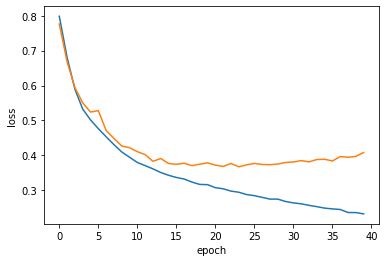

In [245]:
visualizer(train_losses,valid_losses,'loss')

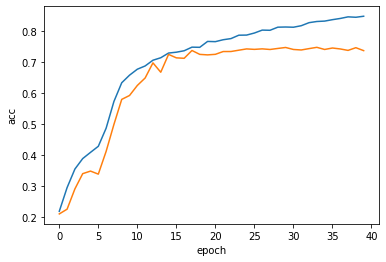

In [246]:
visualizer(train_accs,valid_accs,'acc')

With max-pooling

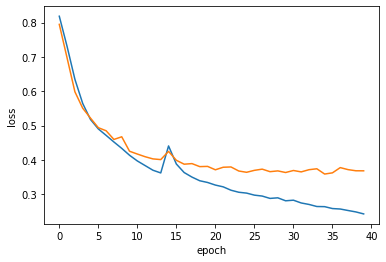

In [167]:
visualizer(train_losses,valid_losses,'loss')

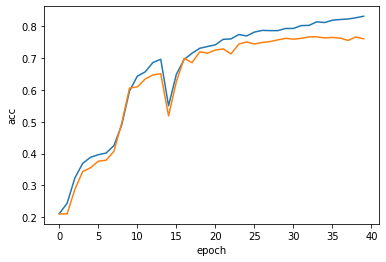

In [168]:
visualizer(train_accs,valid_accs,'acc')

#Inference

In [247]:
test=pd.read_csv("/content/drive/MyDrive/vietnamese_students_feedback/raw_dataset/test.csv")

In [248]:
test_x=test['sentence'].tolist()
test_y=test['topic'].tolist()

In [249]:
embedding_dim=300
hidden_dim=128
num_vocabs=len(vocabs)
num_pos_tags=len(pos_tags)
num_labels=4
drop_rate=0.1

model=BiLSTMClassificier(embedding_dim,hidden_dim,num_vocabs,num_pos_tags,num_labels,
                         drop_rate=drop_rate)

In [250]:
ckpt_path = "/content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/"
max_to_keep=5

ckpt = tf.train.Checkpoint(model=model,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, ckpt_path, max_to_keep=max_to_keep)

In [251]:
# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print(f'Loading the latest checkpoint from {ckpt_manager.latest_checkpoint}')
else:
  print('Initializing the new checkpoint')

Loading the latest checkpoint from /content/drive/MyDrive/vietnamese_students_feedback/models/last-hidden/ckpt-20


In [252]:
test_pred=[]
bar=tqdm(test_x)
for sample in test_x:

  inputs=[create_input_ids(sample)]
  input_ids=tf.constant([i[0] for i in inputs],dtype=tf.int32)
  pos_ids=tf.constant([i[1] for i in inputs],dtype=tf.int32)

  
  
  logits=model(input_ids=input_ids,pos_ids=pos_ids,training=False)
  probs=tf.nn.softmax(logits,axis=-1)
  label=tf.argmax(probs,axis=-1)
  test_pred.append(label.numpy())
  bar.update()
  

  0%|          | 0/3166 [00:00<?, ?it/s]

with last hidden

In [253]:
print(classification_report(test_y,test_pred,digits=5))

              precision    recall  f1-score   support

           0    0.90235   0.95633   0.92856      2290
           1    0.76031   0.67657   0.71600       572
           2    0.85065   0.90345   0.87625       145
           3    0.48684   0.23270   0.31489       159

    accuracy                        0.86702      3166
   macro avg    0.75004   0.69226   0.70893      3166
weighted avg    0.85345   0.86702   0.85694      3166



In [254]:
confusion_matrix(test_y,test_pred)

array([[2190,   76,    7,   17],
       [ 156,  387,    8,   21],
       [   4,    9,  131,    1],
       [  77,   37,    8,   37]])

With max pooling

In [175]:
print(classification_report(test_y,test_pred,digits=5))

              precision    recall  f1-score   support

           0    0.89724   0.96463   0.92971      2290
           1    0.76600   0.66958   0.71455       572
           2    0.96491   0.75862   0.84942       145
           3    0.61111   0.34591   0.44177       159

    accuracy                        0.87081      3166
   macro avg    0.80982   0.68469   0.73386      3166
weighted avg    0.86226   0.87081   0.86266      3166



In [176]:
confusion_matrix(test_y,test_pred)

array([[2209,   64,    1,   16],
       [ 173,  383,    2,   14],
       [   4,   26,  110,    5],
       [  76,   27,    1,   55]])

Future works
- Need to clean data
- Improve pretrained word embedding